# 코로나로 인한 배달 트렌드 변화 분석

### 공정거래위원회에 따르면, 지난  2020년 국내 배달 음식 시장 규모는 23조로 추산되며, 2017년의 15조원과 비교하면 53% 이상 증가한 양상을 보였다. 2020년 1월 국내 첫 코로나19 확진 환자가 발생한 이후로 정부는 코로나 19 방역을 위해 외출과 외식을 삼가고 배달과 포장 이용을 권장했다. 비대면 외식을 늘리기 위해 배달 애플리케이션과 연계하여 4차례 결제를 하면 1만원을 환급해주는 정책도 시행했다. 

### 이러한 배경에서 배달 트렌드가 어떻게 변화되었고, 앞으로는 어떤 흐름을 보일지 관심이 생겨서 서울을 중심으로 배달 데이터 분석을 실시하려 한다.


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns


## 데이터 파일 불러오기

#### 2020년 2월을 기준으로 이전을 프리코로나(pre-corona19) 시대로, 이후를 포스트코로나(post-corona19) 시대로 설정

#### 음식 배달의 빈도가 가장 높은 지역인 서울에 초점을 맞추어 서울지역의 데이터를 추출

In [23]:
case = pd.read_csv('C:/Users/USER/Documents/Case.csv')
timeprovince = pd.read_csv('C:/Users/USER/Documents/TimeProvince.csv')

adstrd = pd.read_csv('C:/Users/USER/Documents/adstrd_master.csv')
delivery = pd.read_csv('C:/Users/USER/Documents/delivery.csv')

## Case 데이터를 통해 지역별 코로나 발생 현황 파악

#### 전국 가운데 서울이 코로나 19 환자 발생수가 많은지 확인

In [25]:
case

,case_id,province,city,group,infection_case,confirmed,latitude,longitude
0,1000001,서울,용산구,True,Itaewon Clubs,139,37.538621,126.992652
1,1000002,서울,관악구,True,Richway,119,37.48208,126.901384
2,1000003,서울,구로구,True,Guro-gu Call Center,95,37.508163,126.884387
3,1000004,서울,양천구,True,Yangcheon Table Tennis Club,43,37.546061,126.874209
4,1000005,서울,도봉구,True,Day Care Center,43,37.679422,127.044374
...,...,...,...,...,...,...,...,...
169,6100012,경상남도,-,False,etc,20,-,-
170,7000001,제주도,-,False,overseas inflow,14,-,-
171,7000002,제주도,-,False,contact with patient,0,-,-
172,7000003,제주도,-,False,etc,4,-,-


C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50872 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44396 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 50872 missing from current f

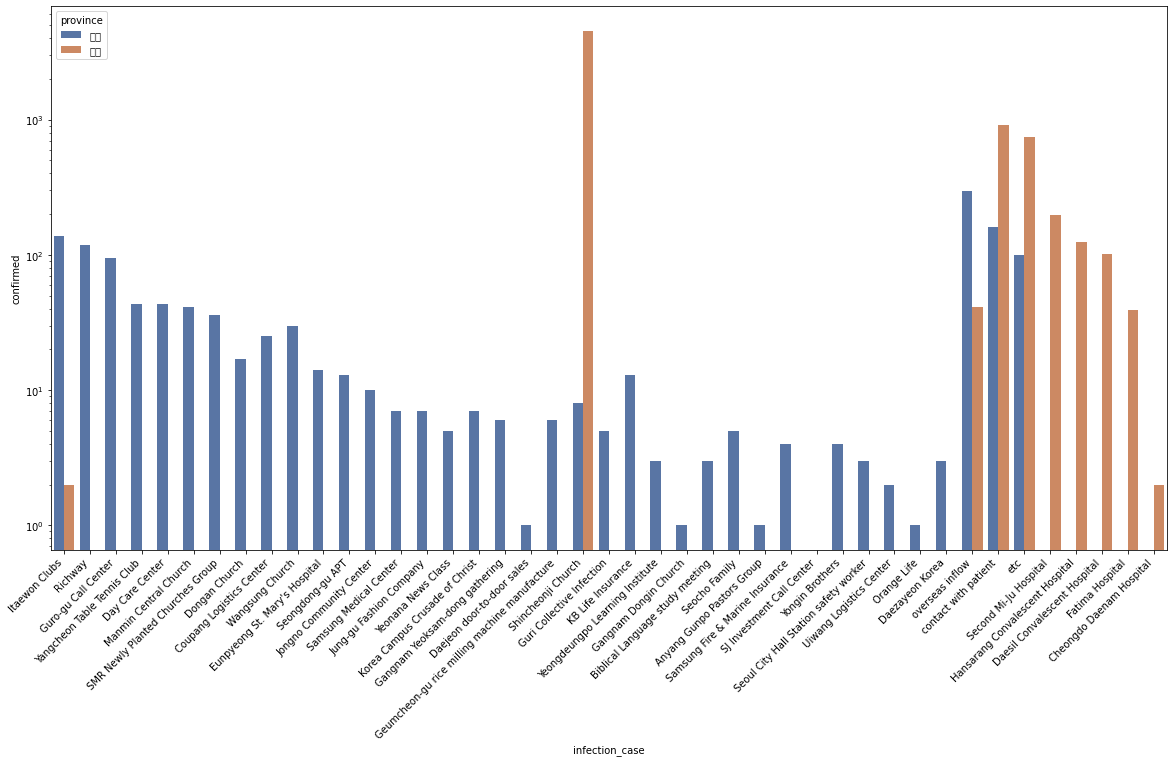

In [21]:
case1 = case[(case['province']=='대구') | (case['province']=='서울')]  #가장 확진자가 많았던 두 지역 확산 원인 확인

plt.figure(figsize = (20,10))
sns.barplot(data = case1, x = 'infection_case', y = 'confirmed', hue='province', palette="deep")
plt.xticks(rotation=45, horizontalalignment='right')
plt.yscale('log')

#### 위 그래프를 통해 서울의 코로나 19 환자 발생 주원인을 알아본다. 서울은 해외 유입, 감염자 접촉, 기타, 이태원 클럽, 리치웨이, 구로구 콜센터 순으로 코로나 19 환자가 많이 발생했다. (대구의 신천지 교회 발 코로나 19 환자의 수가 너무 커서 log 처리을 했음)

## timeprovince 데이터를 통해 지역별 코로나19 확진, 격리해제, 사망의 수 파악

#### timeprovince 데이터는 시계열 데이터이므로 시간의 흐름에 따른 코로나19 현황을 파악할 수 있음

In [32]:
timeprovince

,date,time,province,confirmed,released,deceased
0,2020-01-20,16,서울,0,0,0
1,2020-01-20,16,부산,0,0,0
2,2020-01-20,16,대구,0,0,0
3,2020-01-20,16,인천,1,0,0
4,2020-01-20,16,광주,0,0,0
...,...,...,...,...,...,...
2766,2020-06-30,0,전라북도,27,21,0
2767,2020-06-30,0,전라남도,24,19,0
2768,2020-06-30,0,경상북도,1389,1328,54
2769,2020-06-30,0,경상남도,134,128,0


In [36]:
timeprov = timeprovince[(timeprovince['province']=='서울')]

# data 데이터에서 month만 추출하여 월별 추이를 확인
def grap_month(data):
    data = str(data)
    return str(data[6:7])+'월'

timeprov['month'] = timeprov['date'].apply(lambda x: grap_month(x))

<ipython-input-36-6463030b7157>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeprov_sd['month'] = timeprov_sd['date'].apply(lambda x: grap_month(x))


In [37]:
timeprov

,date,time,province,confirmed,released,deceased,month
0,2020-01-20,16,서울,0,0,0,1월
17,2020-01-21,16,서울,0,0,0,1월
34,2020-01-22,16,서울,0,0,0,1월
51,2020-01-23,16,서울,0,0,0,1월
68,2020-01-24,16,서울,0,0,0,1월
...,...,...,...,...,...,...,...
2686,2020-06-26,0,서울,1267,843,7,6월
2703,2020-06-27,0,서울,1284,911,7,6월
2720,2020-06-28,0,서울,1298,923,7,6월
2737,2020-06-29,0,서울,1305,942,7,6월


<AxesSubplot:xlabel='month', ylabel='confirmed'>

C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50872 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 50872 missing from current fon

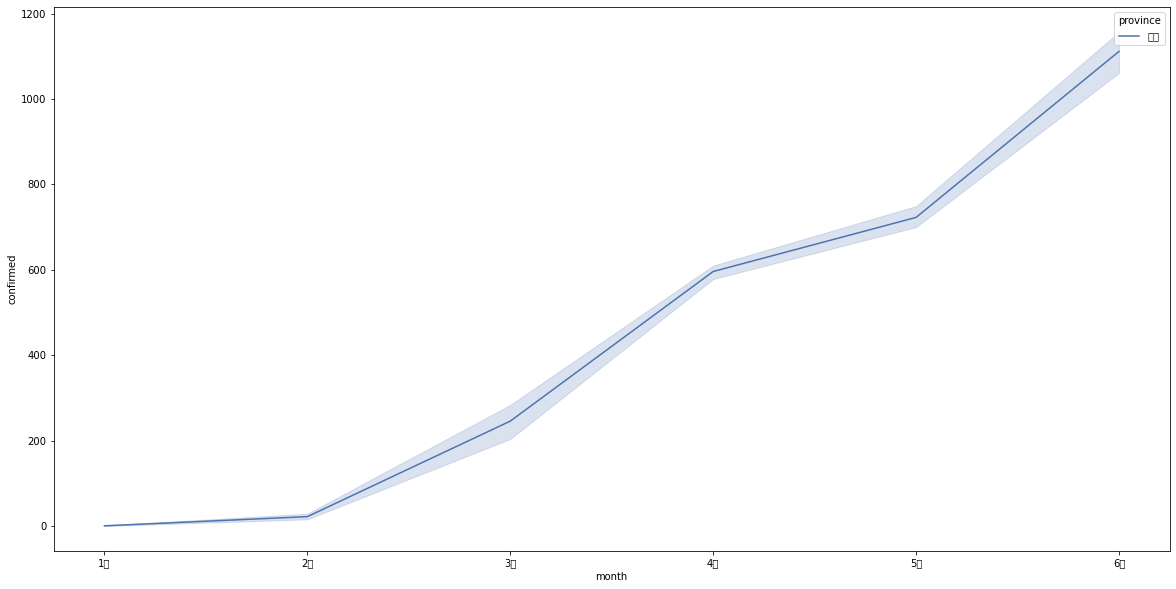

In [40]:
#확진자 발생 추이 시각화하여 확인: 증가함수의 형태를 보임
plt.figure(figsize = (20,10))
sns.lineplot(data = timeprov, x ='month', y ='confirmed', hue='province', palette="deep") 


## adstrd 데이터를 통해 행정동별 데이터 확인

#### 서울에는 425개의 행정구역이 존재함을 확인

In [41]:
adstrd.adstrd_code = adstrd.adstrd_code.astype(int)
adstrd

,adstrd_code,adstrd_nm,brtc_nm,signgu_nm
0,11110515,청운효자동,서울특별시,종로구
1,11110530,사직동,서울특별시,종로구
2,11110540,삼청동,서울특별시,종로구
3,11110550,부암동,서울특별시,종로구
4,11110560,평창동,서울특별시,종로구
...,...,...,...,...
3488,50130580,서홍동,제주특별자치도,서귀포시
3489,50130590,대륜동,제주특별자치도,서귀포시
3490,50130600,대천동,제주특별자치도,서귀포시
3491,50130610,중문동,제주특별자치도,서귀포시


In [42]:
seoul = adstrd[adstrd['brtc_nm']=='서울특별시']
seoul

,adstrd_code,adstrd_nm,brtc_nm,signgu_nm
0,11110515,청운효자동,서울특별시,종로구
1,11110530,사직동,서울특별시,종로구
2,11110540,삼청동,서울특별시,종로구
3,11110550,부암동,서울특별시,종로구
4,11110560,평창동,서울특별시,종로구
...,...,...,...,...
420,11740650,성내2동,서울특별시,강동구
421,11740660,성내3동,서울특별시,강동구
422,11740685,길동,서울특별시,강동구
423,11740690,둔촌1동,서울특별시,강동구


## delivery: 서울지역의 배달 데이터

In [43]:
deli = delivery[(delivery['DLVR_STORE_SIDO']=='서울특별시')]

# date 중에 월별 데이터 분석을 위해 month 데이터 추출
def grap_month(data):
    data = str(data)
    return str(data[6:7])+'월'

deli['month'] = deli['PROCESS_DT'].apply(lambda x: grap_month(x))
deli

<ipython-input-43-a3da781e793c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deli_sd['month'] = deli_sd['PROCESS_DT'].apply(lambda x: grap_month(x))


,SERIAL_NUMBER,PROCESS_DT,DLVR_RQESTER_ID,DLVR_REQUST_STTUS_VALUE,DLVR_RCEPT_CMPNY_ID,DLVR_STORE_ID,DLVR_STORE_INDUTY_NM,DLVR_STORE_LEGALDONG_CODE,DLVR_STORE_SIDO,DLVR_STORE_SIGUNGU,DLVR_STORE_DONG,DLVR_STORE_RI,DLVR_STORE_ADSTRD_CODE,DLVR_STORE_RDNMADR_CODE,DLVR_DSTN_LEGALDONG_CODE,DLVR_DSTN_SIDO,DLVR_DSTN_SIGUNGU,DLVR_DSTN_DONG,DLVR_DSTN_RI,DLVR_DSTN_ADSTRD_CODE,DLVR_DSTN_RDNMADR_CODE,DLVR_MAN_ID,DLVR_AMOUNT,CALL_RLAY_FEE_AMOUNT,GOODS_AMOUNT,SETLE_KND_VALUE,SETLE_CARD_CN,DLVR_RCEPT_TIME,DLVR_CARALC_TIME,DLVR_COMPT_TIME,DLVR_CANCL_TIME,month
2,4577988,2020-01-01,C000129,1,C000129,S0025740,치킨,1138010400,서울특별시,은평구,갈현동,NaN,1138055100,1.138041e+11,1.138010e+09,서울특별시,은평구,갈현동,NaN,1.138055e+09,1.138041e+11,D0001536,3300,300,23000,3,승인:,2020-01-01 00:01:14,2020-01-01 00:01:47,2020-01-01 00:18:47,NaN,1월
6,4577994,2020-01-01,C000049,1,C000049,S0022461,분식,1153010800,서울특별시,구로구,오류동,NaN,1153077000,1.153030e+11,1.153011e+09,서울특별시,구로구,궁동,NaN,1.153079e+09,1.153041e+11,D0004461,3800,300,28000,2,NaN,2020-01-01 01:27:00,2020-01-01 01:27:47,2020-01-01 01:41:45,NaN,1월
8,4577996,2020-01-01,C000104,1,C000101,S0021988,치킨,1156013300,서울특별시,영등포구,대림동,NaN,1156070000,1.156042e+11,1.156013e+09,서울특별시,영등포구,신길동,NaN,1.156052e+09,1.156031e+11,D0006259,4800,200,17000,1,승인:KB국민카드,2020-01-01 00:51:49,2020-01-01 00:52:12,2020-01-01 01:23:41,NaN,1월
24,4578014,2020-01-01,C000101,1,C000104,S0021942,치킨,1156013200,서울특별시,영등포구,신길동,NaN,1156068000,1.156031e+11,1.156013e+09,서울특별시,영등포구,대림동,NaN,1.156071e+09,NaN,D0006407,3900,300,19000,2,NaN,2020-01-01 00:02:53,2020-01-01 00:16:01,2020-01-01 00:42:53,NaN,1월
29,4578020,2020-01-01,C000209,1,C000209,S0022364,치킨,1154510200,서울특별시,금천구,독산동,NaN,1154563000,1.154531e+11,1.162010e+09,서울특별시,관악구,신림동,NaN,1.162072e+09,1.162042e+11,D0003816,4300,300,21000,1,승인:하나카드,2020-01-01 01:27:08,2020-01-01 01:27:25,2020-01-01 01:37:01,NaN,1월
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5158277,10672639,2020-06-21,C000129,1,C000129,S0035127,회,1138010400,서울특별시,은평구,갈현동,NaN,1138055100,1.138030e+11,1.138011e+09,서울특별시,은평구,대조동,NaN,1.138057e+09,1.138031e+11,D0008283,3500,400,28000,2,NaN,2020-06-21 23:37:12,2020-06-21 23:37:22,2020-06-21 23:46:17,NaN,6월
5158279,10672642,2020-06-21,C000049,1,C000237,S0022444,한식,1153010600,서울특별시,구로구,고척동,NaN,1153073000,1.153041e+11,1.153011e+09,서울특별시,구로구,고척동,NaN,1.153073e+09,1.153041e+11,D0004261,3300,300,18900,2,NaN,2020-06-21 23:04:02,2020-06-21 23:08:38,2020-06-21 23:18:13,NaN,6월
5158298,10672664,2020-06-21,C000209,1,C000210,S0019627,배달전문업체,1154510200,서울특별시,금천구,독산동,NaN,1154564000,1.154542e+11,1.154510e+09,서울특별시,금천구,가산동,NaN,1.154551e+09,1.154542e+11,D0006912,3300,200,21900,2,NaN,2020-06-21 23:37:27,2020-06-21 23:38:01,2020-06-21 23:48:26,NaN,6월
5158320,10672689,2020-06-21,C000026,1,C000026,S0026242,야식,1132010800,서울특별시,도봉구,도봉동,NaN,1132052100,1.132041e+11,1.135010e+09,서울특별시,노원구,상계동,NaN,1.135063e+09,1.135041e+11,D0006251,3600,55,22000,2,NaN,2020-06-21 22:57:15,2020-06-21 22:58:00,2020-06-21 23:18:20,NaN,6월


In [44]:
deli.DLVR_REQUST_STTUS_VALUE.value_counts()

1    779456
2     11582
3         2
4         1
Name: DLVR_REQUST_STTUS_VALUE, dtype: int64

#### 1에 해당하는 779456 건만 배달이 정상적으로 완료된 상태이기 때문에 1에 해당하는 데이터만 다룬다.

In [45]:
deli = deli[deli.DLVR_REQUST_STTUS_VALUE==1]

deli['counts'] = 1
deli2 = deli.groupby(['DLVR_STORE_SIDO','month'])[['GOODS_AMOUNT','counts']].sum().reset_index(drop = False)

<ipython-input-45-f7ef7e98cd27>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deli_sd['counts'] = 1


In [46]:
deli2

,DLVR_STORE_SIDO,month,GOODS_AMOUNT,counts
0,서울특별시,1월,3052372755,134861
1,서울특별시,2월,3209041058,143218
2,서울특별시,3월,3424283360,151942
3,서울특별시,4월,3175885857,140996
4,서울특별시,5월,3267822303,142991
5,서울특별시,6월,1476503379,65448


In [47]:
deli[deli['DLVR_STORE_SIDO']=='서울특별시'].isnull().sum()

SERIAL_NUMBER                     0
PROCESS_DT                        0
DLVR_RQESTER_ID                   0
DLVR_REQUST_STTUS_VALUE           0
DLVR_RCEPT_CMPNY_ID               0
DLVR_STORE_ID                     0
DLVR_STORE_INDUTY_NM              0
DLVR_STORE_LEGALDONG_CODE         0
DLVR_STORE_SIDO                   0
DLVR_STORE_SIGUNGU                0
DLVR_STORE_DONG                   0
DLVR_STORE_RI                779456
DLVR_STORE_ADSTRD_CODE            0
DLVR_STORE_RDNMADR_CODE       12698
DLVR_DSTN_LEGALDONG_CODE       6028
DLVR_DSTN_SIDO                 6028
DLVR_DSTN_SIGUNGU              6028
DLVR_DSTN_DONG                 6028
DLVR_DSTN_RI                 779456
DLVR_DSTN_ADSTRD_CODE          5846
DLVR_DSTN_RDNMADR_CODE        33119
DLVR_MAN_ID                       0
DLVR_AMOUNT                       0
CALL_RLAY_FEE_AMOUNT              0
GOODS_AMOUNT                      0
SETLE_KND_VALUE                   0
SETLE_CARD_CN                597047
DLVR_RCEPT_TIME             

In [48]:
deli.groupby(['DLVR_STORE_SIDO','DLVR_STORE_INDUTY_NM'])['DLVR_AMOUNT','counts'].sum()

<ipython-input-48-ab493f94d488>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  deli_sd.groupby(['DLVR_STORE_SIDO','DLVR_STORE_INDUTY_NM'])['DLVR_AMOUNT','counts'].sum()


DLVR_AMOUNT  counts
DLVR_STORE_SIDO DLVR_STORE_INDUTY_NM                     
서울특별시           도시락                      13410100    3691
                돈까스/일식                   83165680   22201
                배달전문업체                    4096000    1122
                분식                      404632160  109634
                아시안/양식                   89388840   23045
                야식                      123546430   31298
                족발/보쌈                   224731380   59204
                중식                       77936190   21550
                찜탕                       47254230   12497
                치킨                      795219770  211342
                카페/디저트                  273239230   78672
                패스트푸드                   320639430   92140
                피자                      155572510   41722
                한식                      220717772   58640
                회                        48166500   12698

In [49]:
induty = deli.groupby(['DLVR_STORE_SIDO','DLVR_STORE_INDUTY_NM'])['DLVR_AMOUNT','counts'].sum().reset_index(drop = False)
induty

<ipython-input-49-ba0d1809a162>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  induty_sd = deli_sd.groupby(['DLVR_STORE_SIDO','DLVR_STORE_INDUTY_NM'])['DLVR_AMOUNT','counts'].sum().reset_index(drop = False)


,DLVR_STORE_SIDO,DLVR_STORE_INDUTY_NM,DLVR_AMOUNT,counts
0,서울특별시,도시락,13410100,3691
1,서울특별시,돈까스/일식,83165680,22201
2,서울특별시,배달전문업체,4096000,1122
3,서울특별시,분식,404632160,109634
4,서울특별시,아시안/양식,89388840,23045
5,서울특별시,야식,123546430,31298
6,서울특별시,족발/보쌈,224731380,59204
7,서울특별시,중식,77936190,21550
8,서울특별시,찜탕,47254230,12497
9,서울특별시,치킨,795219770,211342


C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 46973 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 46024 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44620 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49828 missing from current

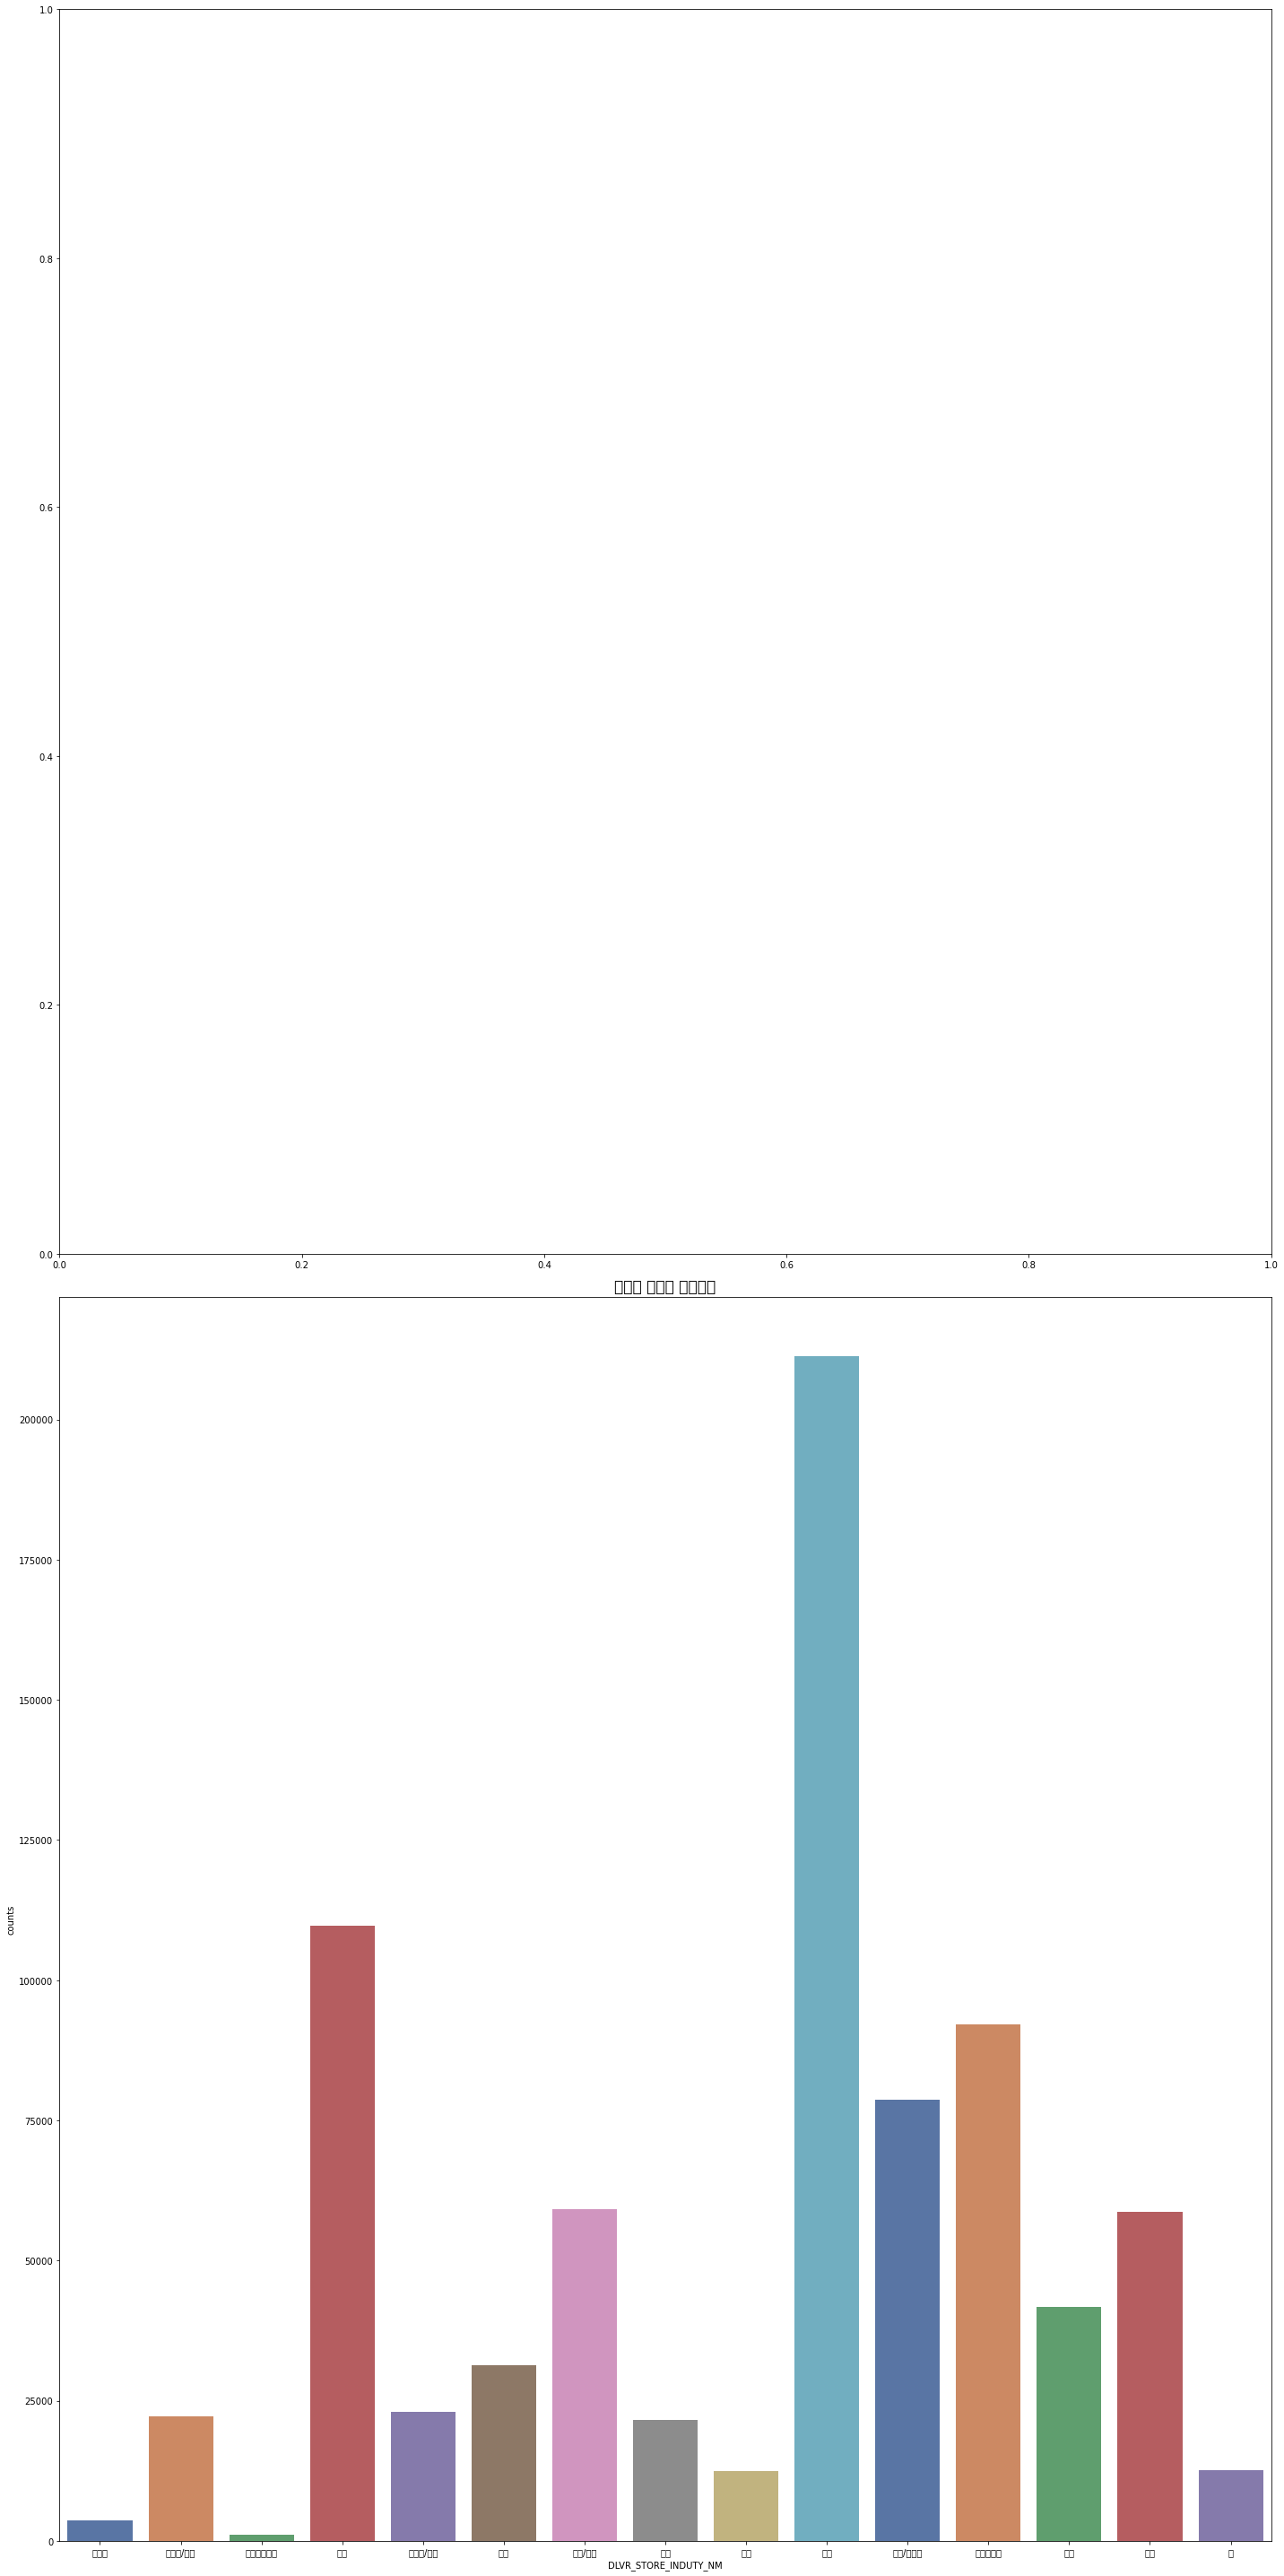

In [50]:
f,ax = plt.subplots(2,1,figsize=(20,40))

sns.barplot(data = induty[induty['DLVR_STORE_SIDO']=='서울특별시'], x ='DLVR_STORE_INDUTY_NM', y ='counts', palette='deep' ,ax=ax[1])
ax[1].set_title('서울시 업종별 이용금액', fontsize=17)

plt.tight_layout()
plt.show()

#### 업종별 분석 히스토그램을 통해 치킨과 분식 카테고리 배달 건수가 눈에 띄게 많음을 확인할 수 있다.

<AxesSubplot:xlabel='DLVR_STORE_INDUTY_NM'>

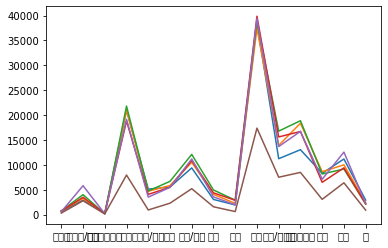

In [65]:
t_induty = deli.groupby(['DLVR_STORE_SIDO','month','DLVR_STORE_INDUTY_NM']).counts.sum().reset_index(drop = False)
t_pivot= t_induty[t_induty['DLVR_STORE_SIDO']=='서울특별시'].pivot(index='DLVR_STORE_INDUTY_NM',columns='month',values='counts')

plt.plot(t_pivot)
t_pivot.plot.bar(stacked=True, rot=0, ax=ax[1])


#### 월별 분석에도 여전히 치킨과 분석이 가장 많은 주문수를 보이고 있다.

In [83]:
sl_deli = deli[(deli['DLVR_STORE_SIDO']=='서울특별시')]
sl_deli

,SERIAL_NUMBER,PROCESS_DT,DLVR_RQESTER_ID,DLVR_REQUST_STTUS_VALUE,DLVR_RCEPT_CMPNY_ID,DLVR_STORE_ID,DLVR_STORE_INDUTY_NM,DLVR_STORE_LEGALDONG_CODE,DLVR_STORE_SIDO,DLVR_STORE_SIGUNGU,DLVR_STORE_DONG,DLVR_STORE_RI,DLVR_STORE_ADSTRD_CODE,DLVR_STORE_RDNMADR_CODE,DLVR_DSTN_LEGALDONG_CODE,DLVR_DSTN_SIDO,DLVR_DSTN_SIGUNGU,DLVR_DSTN_DONG,DLVR_DSTN_RI,DLVR_DSTN_ADSTRD_CODE,DLVR_DSTN_RDNMADR_CODE,DLVR_MAN_ID,DLVR_AMOUNT,CALL_RLAY_FEE_AMOUNT,GOODS_AMOUNT,SETLE_KND_VALUE,SETLE_CARD_CN,DLVR_RCEPT_TIME,DLVR_CARALC_TIME,DLVR_COMPT_TIME,DLVR_CANCL_TIME,month,counts
2,4577988,2020-01-01,C000129,1,C000129,S0025740,치킨,1138010400,서울특별시,은평구,갈현동,NaN,1138055100,1.138041e+11,1.138010e+09,서울특별시,은평구,갈현동,NaN,1.138055e+09,1.138041e+11,D0001536,3300,300,23000,3,승인:,2020-01-01 00:01:14,2020-01-01 00:01:47,2020-01-01 00:18:47,NaN,1월,1
6,4577994,2020-01-01,C000049,1,C000049,S0022461,분식,1153010800,서울특별시,구로구,오류동,NaN,1153077000,1.153030e+11,1.153011e+09,서울특별시,구로구,궁동,NaN,1.153079e+09,1.153041e+11,D0004461,3800,300,28000,2,NaN,2020-01-01 01:27:00,2020-01-01 01:27:47,2020-01-01 01:41:45,NaN,1월,1
8,4577996,2020-01-01,C000104,1,C000101,S0021988,치킨,1156013300,서울특별시,영등포구,대림동,NaN,1156070000,1.156042e+11,1.156013e+09,서울특별시,영등포구,신길동,NaN,1.156052e+09,1.156031e+11,D0006259,4800,200,17000,1,승인:KB국민카드,2020-01-01 00:51:49,2020-01-01 00:52:12,2020-01-01 01:23:41,NaN,1월,1
24,4578014,2020-01-01,C000101,1,C000104,S0021942,치킨,1156013200,서울특별시,영등포구,신길동,NaN,1156068000,1.156031e+11,1.156013e+09,서울특별시,영등포구,대림동,NaN,1.156071e+09,NaN,D0006407,3900,300,19000,2,NaN,2020-01-01 00:02:53,2020-01-01 00:16:01,2020-01-01 00:42:53,NaN,1월,1
29,4578020,2020-01-01,C000209,1,C000209,S0022364,치킨,1154510200,서울특별시,금천구,독산동,NaN,1154563000,1.154531e+11,1.162010e+09,서울특별시,관악구,신림동,NaN,1.162072e+09,1.162042e+11,D0003816,4300,300,21000,1,승인:하나카드,2020-01-01 01:27:08,2020-01-01 01:27:25,2020-01-01 01:37:01,NaN,1월,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5158277,10672639,2020-06-21,C000129,1,C000129,S0035127,회,1138010400,서울특별시,은평구,갈현동,NaN,1138055100,1.138030e+11,1.138011e+09,서울특별시,은평구,대조동,NaN,1.138057e+09,1.138031e+11,D0008283,3500,400,28000,2,NaN,2020-06-21 23:37:12,2020-06-21 23:37:22,2020-06-21 23:46:17,NaN,6월,1
5158279,10672642,2020-06-21,C000049,1,C000237,S0022444,한식,1153010600,서울특별시,구로구,고척동,NaN,1153073000,1.153041e+11,1.153011e+09,서울특별시,구로구,고척동,NaN,1.153073e+09,1.153041e+11,D0004261,3300,300,18900,2,NaN,2020-06-21 23:04:02,2020-06-21 23:08:38,2020-06-21 23:18:13,NaN,6월,1
5158298,10672664,2020-06-21,C000209,1,C000210,S0019627,배달전문업체,1154510200,서울특별시,금천구,독산동,NaN,1154564000,1.154542e+11,1.154510e+09,서울특별시,금천구,가산동,NaN,1.154551e+09,1.154542e+11,D0006912,3300,200,21900,2,NaN,2020-06-21 23:37:27,2020-06-21 23:38:01,2020-06-21 23:48:26,NaN,6월,1
5158320,10672689,2020-06-21,C000026,1,C000026,S0026242,야식,1132010800,서울특별시,도봉구,도봉동,NaN,1132052100,1.132041e+11,1.135010e+09,서울특별시,노원구,상계동,NaN,1.135063e+09,1.135041e+11,D0006251,3600,55,22000,2,NaN,2020-06-21 22:57:15,2020-06-21 22:58:00,2020-06-21 23:18:20,NaN,6월,1


C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 51228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48708 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50984 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50872 missing from current

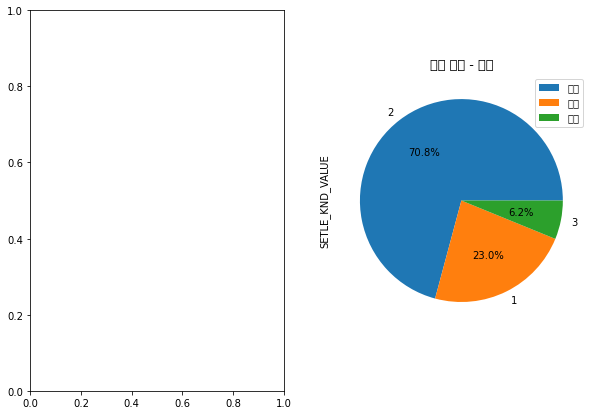

In [85]:
f,ax = plt.subplots(1,2,figsize=(10,7))

sl_deli.SETLE_KND_VALUE.value_counts().plot.pie(autopct = '%1.1f%%', figsize = [10,7], ax = ax[1])
ax[1].set_title('결제 비율 - 서울', fontsize = 13)

plt.legend(['카드', '선불','현금'])
plt.show()

#### 카드를 통한 결제가 70.8%로 가장 많이 나타났다


In [86]:
p_induty = deli.groupby(['DLVR_STORE_SIDO','month','SETLE_KND_VALUE']).counts.sum().reset_index(drop = False)
p_pivot = p_induty[p_induty['DLVR_STORE_SIDO']=='서울특별시'].pivot(index='month',columns='SETLE_KND_VALUE',values='counts')

C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0, flags=flags)


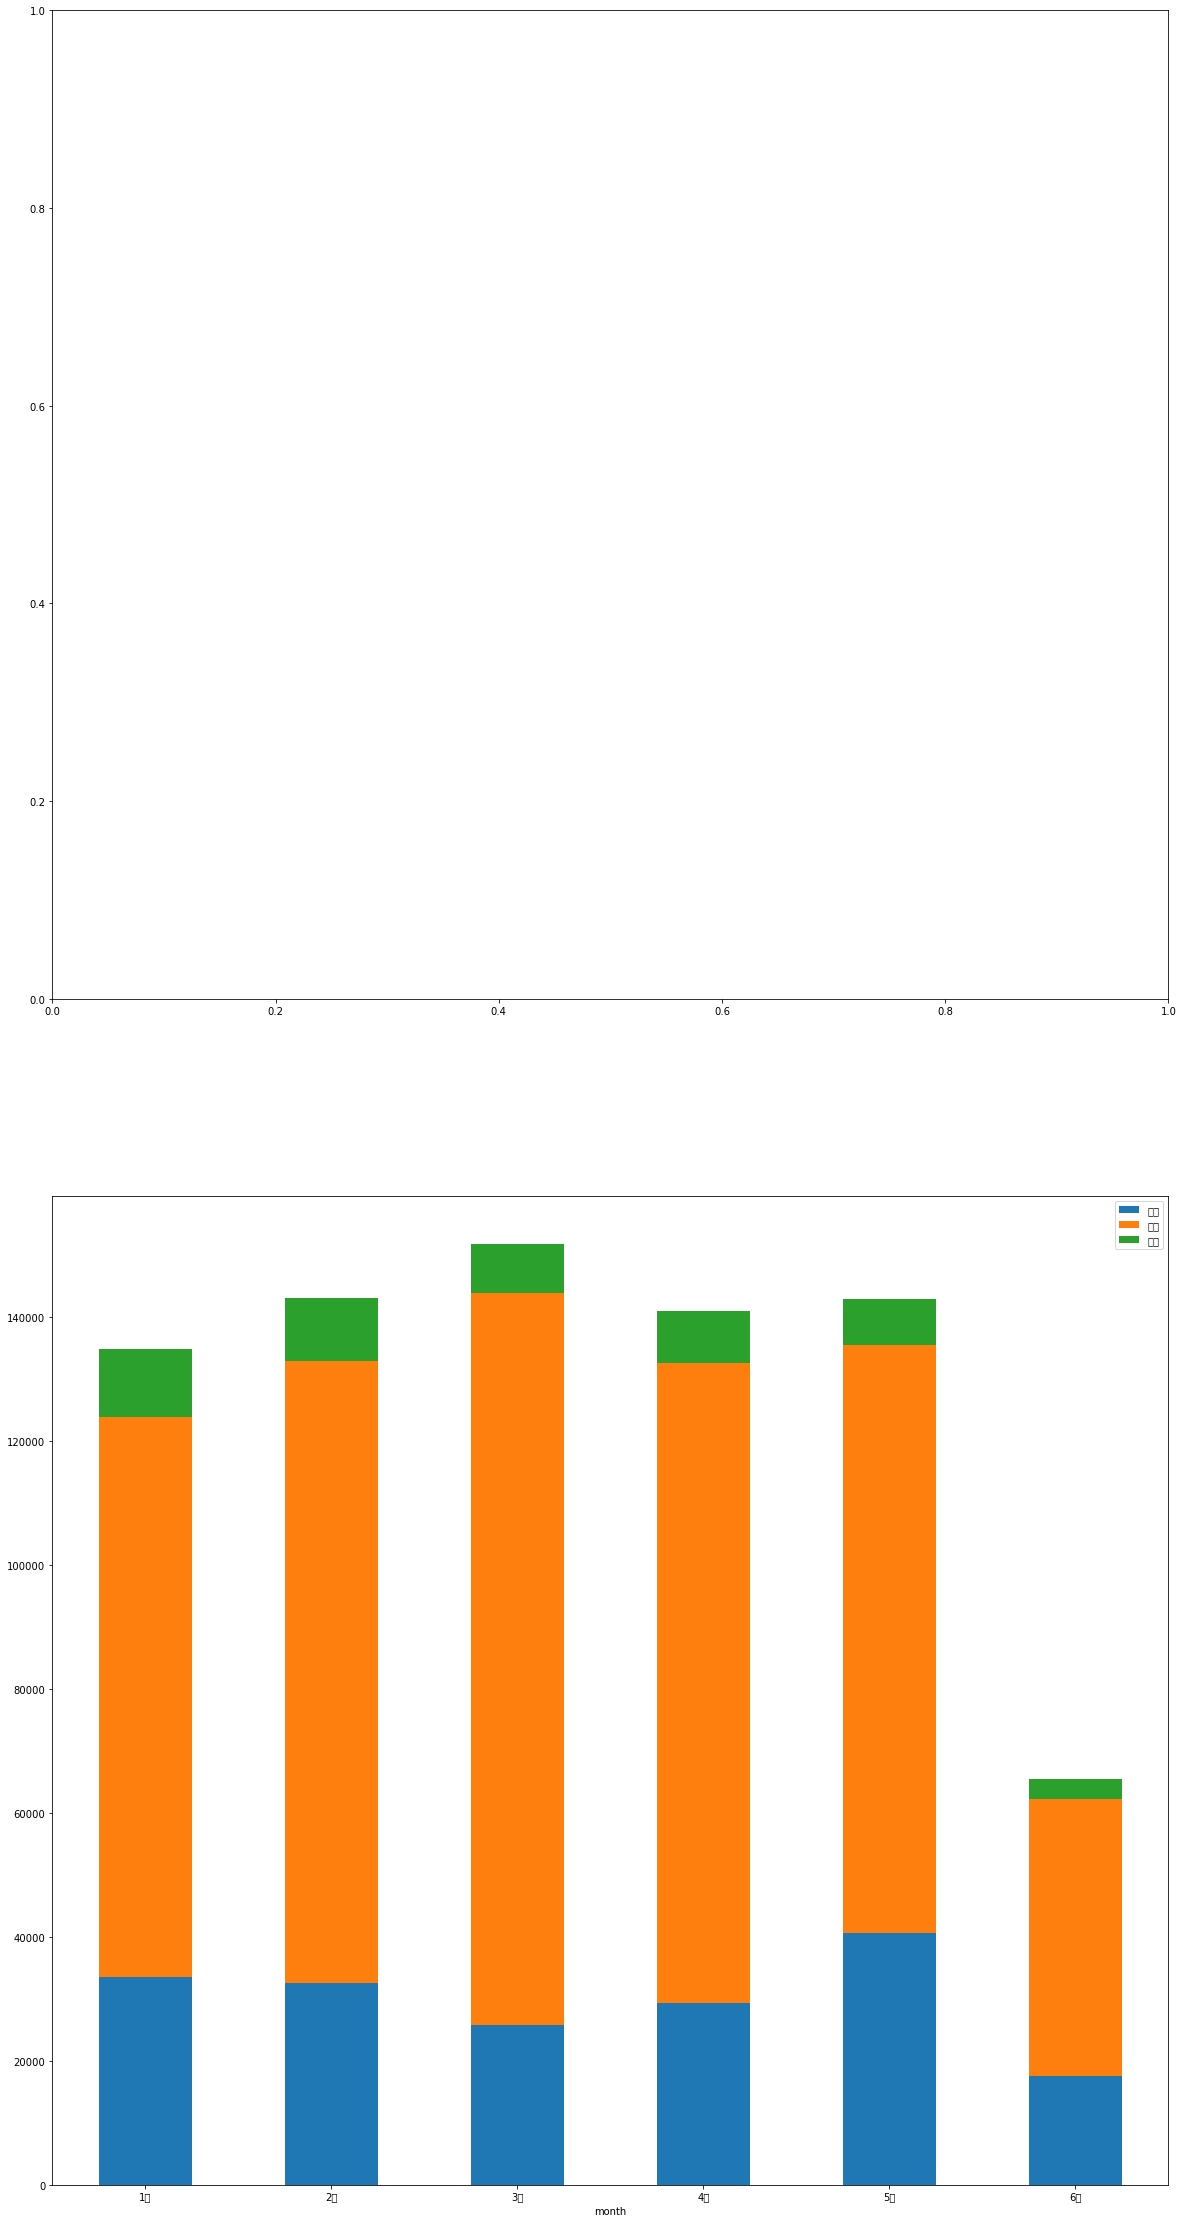

In [89]:
f,ax = plt.subplots(2,1,figsize=(20,40))

p_pivot.plot.bar(stacked=True, rot=0, ax=ax[1])
ax[1].legend(['선불', '카드','현금'])


plt.show()

#### 4월 이후 재난 지원금 정책이 전국적으로 실시 되었던 것을 바탕으로, 배달 이용에 있어서도 현금 결제 비중이 높아졌을 것으로 예상하였으나, 유의미한 차이를 찾기 어려웠다.

C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50872 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 53945 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\USER\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49884 missing from current

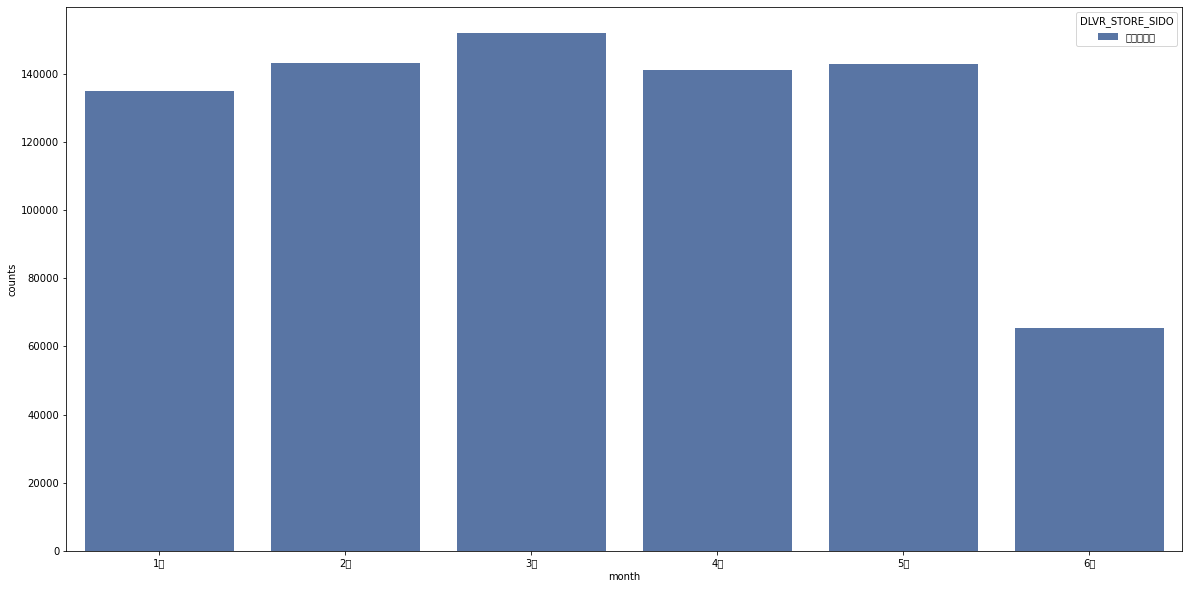

In [90]:
plt.figure(figsize = (20,10))
sns.barplot(data = deli_gr, x ='month', y ='counts', hue='DLVR_STORE_SIDO', palette="deep")
plt.show()

#### 월별 배달이용건수 그래프 상 월별 건수가 증가추세를 보이나 6월에는 배달 이용이 급격하게 감소한 것과 같은 양상을 보인다. 이는 정부재난 지원금 지원으로 선결제의 건수가 증가했기 때문에 이런 양상을 보인 것으로 추측된다. 즉, 배달이용은 코로나 19로 인해 충분히 증가했고, 코로나 19 특수를 본 것이 맞으며, 코로나 19의 종식이 오기 전까지는 계속해서 배달 이용 건수는 증가할 것으로 보인다.